# Mini-Lab #1          
## MSDS 7331-401

#### Project Team:
+ Peter Byrd 
+ Matthew Przybyla  
+ David Tran
+ Amber Whelpley


## Data Cleanup

Before diving into model creation, we will cleanup some of the National Highway Traffic Safety Administration (NHTSA) data for use in our regression and SVM models.


In [1]:
#Importing the Libraries 

import pandas as pd
import numpy as np
from __future__ import print_function 

%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

#Read the Data
df = pd.read_csv("/Users/amber/downloads/accident.csv")

#Review the data
df.head()

,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERNOTMVIT,PERMVIT,PERSONS,COUNTY,...,NOT_MIN,ARR_HOUR,ARR_MIN,HOSP_HR,HOSP_MN,CF1,CF2,CF3,FATALS,DRUNK_DR
0,1,10001,1,1,0,0,0,1,1,127,...,99,2,58,88,88,0,0,0,1,1
1,1,10002,1,1,0,0,0,1,1,83,...,99,22,20,88,88,0,0,0,1,0
2,1,10003,1,1,0,0,0,2,2,11,...,99,1,45,99,99,0,0,0,1,1
3,1,10004,1,1,0,0,0,1,1,45,...,99,1,15,88,88,0,0,0,1,1
4,1,10005,2,2,0,0,0,2,2,45,...,99,7,16,88,88,0,0,0,1,0


To aid in our interpretation, the variables TOT_PERS and TIME were created. TOT_PERS is the sum of all persons involved in each accident including pedestrians.  TIME is simply the hour and minute combined into a single variable. 

In addition, the number of fatalities was converted into a binary variable as our intent is to predict whether an accident results in multiple or single fatalities. This allows us to see that there were 29,816 accidents involving a single fatality and 2,350 resulting in more than one fatality.

Similarly, the work zone and rural/urban attributes were converted to binary variables to simplify analysis.

In [2]:
# Let's combine some attributes for easier interpretation:

# Total number of persons involved in the accident
df['TOT_PERS'] = df['PERMVIT'] + df['PERNOTMVIT'] + df['PEDS']

# Combine HOUR and MINUTE into a single TIME attribute
df['TIME'] = df['HOUR'] + df['MINUTE']/60

# Let's create a binary attribute from FATALS to signify single or multi-person fatality. 
#   We will use 0 to represent a single fatality, and 1 to represent a multi-person fatality.

df['FATALS'] = (df['FATALS'] > 1)*1     # Use a 1 in FATALS if there is more than 1 fatality
df['WRK_ZONE'] = (df['WRK_ZONE']>0)*1   # Use a 1 if in a workzone, 0 if not
df['RUR_URB'] = (df['RUR_URB']<2)*1     # Use a 1 if Urban, 0 if rural
                   
df_fatal = df.groupby(by='FATALS')
# Number of accidents sorted by single fatality or multi-fatality accidents
print (df_fatal.FATALS.count())


FATALS
0    29816
1     2350
Name: FATALS, dtype: int64


Using the correlation matrix from our previous analysis, duplicate attributes and attributes with low correlation to the number of fatalities were removed.

In [3]:
# Remove non-helpful and duplicate attributes 
# Correlation matrix from Lab 1 was used to determine attributes with limited correlation to FATALS
# Some categorical/coded variables were removed

excludeFields = ['ST_CASE','VE_CASE','VE_TOTAL','VE_FORMS','PEDS','PERNOTMVIT','PERMVIT','PERSONS','YEAR','HOUR',
                 'MINUTE','PVH_INVL','NHS','FUNC-SYS','RD_OWNER','ROUTE','TWAY_ID','TYP_INT','CITY','STATE','COUNTY',
                 'TWAY_ID2','MILEPT','SP_JUR','MAN_COLL','RELJCT1','RELJCT2', 'REL_ROAD', 'LGT_COND','DAY','FUNC_SYS',
                 'RAIL','NOT_HOUR','NOT_MIN','ARR_HOUR','ARR_MIN','HOSP_HR','HOSP_MN','CF1','CF2','CF3']

keepFields = [col for col in df.columns if col not in excludeFields]

dfData = df[keepFields]

dfData.head()

,MONTH,DAY_WEEK,RUR_URB,LATITUDE,LONGITUD,HARM_EV,WRK_ZONE,WEATHER1,WEATHER2,WEATHER,SCH_BUS,FATALS,DRUNK_DR,TOT_PERS,TIME
0,1,5,1,33.878653,-87.325328,35,0,1,0,1,0,0,1,1,2.666667
1,1,5,1,34.910442,-86.908708,34,0,10,0,10,0,0,0,1,22.216667
2,1,5,1,32.142006,-85.758456,42,0,1,0,1,0,0,1,2,1.416667
3,1,1,1,31.439814,-85.510300,53,0,10,0,10,0,0,1,1,0.950000
4,1,4,0,31.319331,-85.515100,12,0,1,0,1,0,0,0,2,7.150000


In [4]:
# Impute some missing values and grouped by their

df_grouped = dfData.groupby(by=['HARM_EV'])

# now use this grouping to fill the data set in each group, then transform back
# fill in the numeric values
df_imputed = df_grouped.transform(lambda grp: grp.fillna(grp.median()))

# fill in the categorical values
df_imputed[['HARM_EV']] = df_grouped[['HARM_EV']].apply(lambda grp: grp.fillna(grp.mode()))

# Drop rows that still had missing values after grouped imputation
df_imputed.dropna(inplace=True)

df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32166 entries, 0 to 32165
Data columns (total 15 columns):
MONTH       32166 non-null int64
DAY_WEEK    32166 non-null int64
RUR_URB     32166 non-null int64
LATITUDE    32166 non-null float64
LONGITUD    32166 non-null float64
WRK_ZONE    32166 non-null int64
WEATHER1    32166 non-null int64
WEATHER2    32166 non-null int64
WEATHER     32166 non-null int64
SCH_BUS     32166 non-null int64
FATALS      32166 non-null int64
DRUNK_DR    32166 non-null int64
TOT_PERS    32166 non-null int64
TIME        32166 non-null float64
HARM_EV     32166 non-null int64
dtypes: float64(3), int64(12)
memory usage: 3.9 MB


## Create Models 

Now that we have structured the dataset, we can create our models.  We will use an 80/20 training data to test data split, and 10 fold cross validation.

**Added for Resubmission**

***Stratified Shuffle Split was used in our modeling becaues of the nature of the data set. The data set has a large amount of single-fatalities, which skews the population.***

In [5]:
# Training and Testing Split 80/20 (Split)

#Added for Resubmission the import 
from sklearn.model_selection import StratifiedShuffleSplit

# We want to predict the X and Y values as follows:
if 'FATALS' in df_imputed:
    y = df_imputed['FATALS'].values
    del df_imputed['FATALS']
    x = df_imputed.values 

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 10
num_instances = len(y)
cv_object = StratifiedShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, train_size = 0.80, random_state=1)
cv_object.get_n_splits(x, y)                      
print(cv_object)

#Added for Resubmission 
for train_index, test_index in cv_object.split(x,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

StratifiedShuffleSplit(n_splits=10, random_state=1, test_size=0.2,
            train_size=0.8)
TRAIN: [10298  5849 31914 ..., 20998 23514 25284] TEST: [24083 18290 22859 ...,  2985 27413 30793]
TRAIN: [30676 18003  4719 ..., 27331  6887 10484] TEST: [30366 28359 31188 ..., 18144  7503  3832]
TRAIN: [13093 25004  5248 ..., 31979  3633   727] TEST: [18406 30199 15903 ...,  4773   471  4010]
TRAIN: [23085  8303 15777 ..., 28228  4285 22270] TEST: [28514 14170 27636 ...,  8921 19538 17703]
TRAIN: [ 4470 12124 21060 ..., 23906 31242 24530] TEST: [17446 11745  6398 ...,  7863 23098 29513]
TRAIN: [ 7866 12266 28123 ..., 30791 10688  1084] TEST: [25118  2128 18871 ..., 13902  3298  4021]
TRAIN: [  535  4134 16879 ..., 20316  6519 12527] TEST: [ 3760 14866 28046 ..., 27412 15246 21368]
TRAIN: [26890 18413 11015 ..., 29263 11478 23031] TEST: [ 1108 30148 12863 ...,  8787 14100 16968]
TRAIN: [29338  2207 25476 ...,  2255 25229 26899] TEST: [ 3931 10260   907 ..., 16498 21240 24071]
TRAIN: [28931 


### Logistic Regression

###### Model 1: logistic regression model with parameters Penalty = l2; Cost = 1.0; class_weight = None


In [6]:
# MODEL 1 (Cost = 1.0, class_weight=None)

from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

iter_num=0
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(x,y)):
    lr_clf.fit(x[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(x[test_indices]) # get test set predictions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))


====Iteration 0  ====
accuracy 0.926639726453
confusion matrix
 [[5946   18]
 [ 454   16]]
====Iteration 1  ====
accuracy 0.926173453528
confusion matrix
 [[5945   19]
 [ 456   14]]
====Iteration 2  ====
accuracy 0.925551756295
confusion matrix
 [[5942   22]
 [ 457   13]]
====Iteration 3  ====
accuracy 0.925396331986
confusion matrix
 [[5940   24]
 [ 456   14]]
====Iteration 4  ====
accuracy 0.92508548337
confusion matrix
 [[5941   23]
 [ 459   11]]
====Iteration 5  ====
accuracy 0.924463786136
confusion matrix
 [[5942   22]
 [ 464    6]]
====Iteration 6  ====
accuracy 0.924463786136
confusion matrix
 [[5940   24]
 [ 462    8]]
====Iteration 7  ====
accuracy 0.92601802922
confusion matrix
 [[5947   17]
 [ 459   11]]
====Iteration 8  ====
accuracy 0.925551756295
confusion matrix
 [[5945   19]
 [ 460   10]]
====Iteration 9  ====
accuracy 0.924463786136
confusion matrix
 [[5939   25]
 [ 461    9]]



The accuracy of this first model is good at about 92%, and from the confusion matrices we see a lot of True Positive predictions.  The model appears to predict more False Positives than it does False Negatives, and very few True Negatives.  This model definitely errs on the side of predicting single-fatality accidents.

This phenomenon occurs due to the extremely high number of single-fatality accidents in our data.  The model almost always predicts a single-fatality accident.  Even though there are several multi-fatality accidents, the number of these pale in comparison to single-victim accidents.



###### Model 2: logistic regression model with parameters Penalty = l2; Cost = 0.5; class_weight = 'balanced'

In [7]:
# MODEL 2 (Cost = 0.5, class_weight='balanced')

lr_clf = LogisticRegression(penalty='l2', C=0.5, class_weight='balanced')


iter_num=0
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(x,y)):
    lr_clf.fit(x[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(x[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))


====Iteration 0  ====
accuracy 0.769350326391
confusion matrix
 [[4659 1305]
 [ 179  291]]
====Iteration 1  ====
accuracy 0.7732359341
confusion matrix
 [[4710 1254]
 [ 205  265]]
====Iteration 2  ====
accuracy 0.767796083307
confusion matrix
 [[4636 1328]
 [ 166  304]]
====Iteration 3  ====
accuracy 0.771059993783
confusion matrix
 [[4676 1288]
 [ 185  285]]
====Iteration 4  ====
accuracy 0.77416847995
confusion matrix
 [[4707 1257]
 [ 196  274]]
====Iteration 5  ====
accuracy 0.765309294374
confusion matrix
 [[4618 1346]
 [ 164  306]]
====Iteration 6  ====
accuracy 0.773546782717
confusion matrix
 [[4676 1288]
 [ 169  301]]
====Iteration 7  ====
accuracy 0.778054087659
confusion matrix
 [[4718 1246]
 [ 182  288]]
====Iteration 8  ====
accuracy 0.763133354057
confusion matrix
 [[4624 1340]
 [ 184  286]]
====Iteration 9  ====
accuracy 0.762977929748
confusion matrix
 [[4628 1336]
 [ 189  281]]



The accuracy of this model is significantly lower than the previous model, at approximately 77%. From the confusion matrices we still see a lot of True Positive predictions, but also many more False Negative predictions than the previous model.  There are more True Negatives predictions, but this comes at the cost of a loss in overall accuracy.  This model errs on the side of predicting more multi-fatality accidents than the previous model.

In order to experiment a bit with how much the differing cost affects model accuracy an interactive widget was used (below).

In [8]:
# Cost parameter variation 

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(lr_clf, x, y=y, cv=cv_object)

# here we can change some of the parameters interactively

from ipywidgets import widgets as wd

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None) # get object
    accuracies = cross_val_score(lr_clf,x,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05),__manual=True)

A Jupyter Widget

<function __main__.lr_explor>


Adjusting the Cost of the model has minimal impact on the overall model accuracy.  We moved from 0.15 all the way up to 4.95 without seeing a large difference, and ultimately settled on 0.5 for the cost.


Now let's normalize the features and run the model once again with a Cost of 0.5 and class_weight=None.


In [9]:
from sklearn.preprocessing import StandardScaler

# set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(x,y): 

    X_train = x[train_indices]
    y_train = y[train_indices]
    
    X_test = x[test_indices]
    y_test = y[test_indices]

scl_obj = StandardScaler()
scl_obj.fit(X_train)   

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test)


##### Model 3: scaled logistic regression model with parameters Penalty='l2'; C=0.05; class_weight=None

In [10]:
# MODEL 3 (Normalized, Cost = 0.5, class_weight=None)

from sklearn.preprocessing import StandardScaler

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05,class_weight=None)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set predictions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df_imputed.columns) # combine attributes
for coef, name in sorted(zip_vars):
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.924152937519
[[5939   25]
 [ 463    7]]
TIME has weight of -0.0795538203427
SCH_BUS has weight of -0.0740399556536
LATITUDE has weight of -0.0622129362232
WRK_ZONE has weight of -0.0334989473756
WEATHER has weight of -0.0249829453892
WEATHER2 has weight of -0.0239687039473
DAY_WEEK has weight of 0.00144741144785
WEATHER1 has weight of 0.0246760993869
MONTH has weight of 0.0407834713384
LONGITUD has weight of 0.0512831649608
HARM_EV has weight of 0.133471999859
DRUNK_DR has weight of 0.244592090401
RUR_URB has weight of 0.335168291062
TOT_PERS has weight of 0.654996807289



This model provides good accuracy at about 93%.  There are still a large number of True Positive results.  It tends to predict more False Positive results than False Negative results.

The weights of the attributes were graphed for a visual review and will be discussed later.


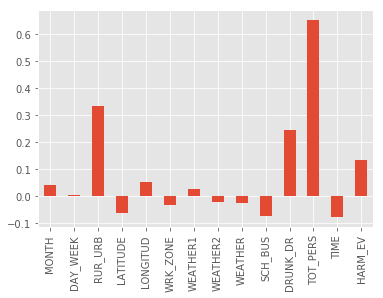

In [11]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Visualizes the variables using matplotlib in a bar chart 
weights = pd.Series(lr_clf.coef_[0],index=df_imputed.columns)
weights.plot(kind='bar')
plt.show()


### Support Vector Machines


In [12]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set predictions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)
 

accuracy: 0.92695057507
[[5964    0]
 [ 470    0]]


**Added for Resubmission**

***For this instance, the accuracy was predicted to be approximately 93% by the SVM. According to the confusion matrix of the model, the results are shown to always be true; therefore, the model is not reliable. ***

***By knowing the nature of our data set, there were a large amount of single-fatality accidents present which led to a higher technical accuracy but not in a useful way. This application is not desirable because no multi-fatality accidents were predicted by this SVM model.***

In [13]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(5677, 14)
(5677,)
[3797 1880]


In [14]:
# Let's look at the instances that were chosen as support vectors

# make a dataframe of the training data
df_tested_on = df_imputed.iloc[train_indices] 
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['FATALS'] = y[svm_clf.support_] # add back in the 'FATALS' Column to the pandas dataframe
df_imputed['FATALS'] = y                   # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5677 entries, 24414 to 15947
Data columns (total 15 columns):
MONTH       5677 non-null int64
DAY_WEEK    5677 non-null int64
RUR_URB     5677 non-null int64
LATITUDE    5677 non-null float64
LONGITUD    5677 non-null float64
WRK_ZONE    5677 non-null int64
WEATHER1    5677 non-null int64
WEATHER2    5677 non-null int64
WEATHER     5677 non-null int64
SCH_BUS     5677 non-null int64
DRUNK_DR    5677 non-null int64
TOT_PERS    5677 non-null int64
TIME        5677 non-null float64
HARM_EV     5677 non-null int64
FATALS      5677 non-null int64
dtypes: float64(3), int64(12)
memory usage: 709.6 KB


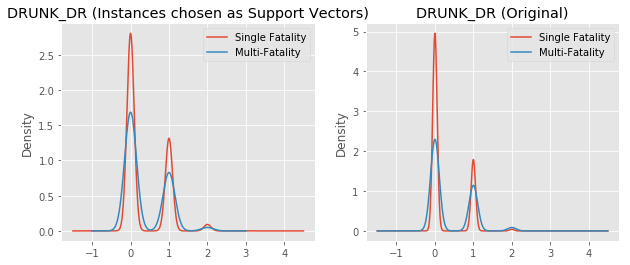

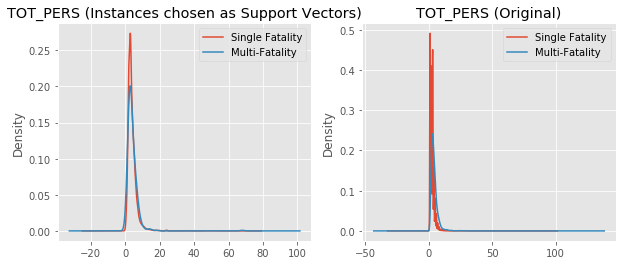

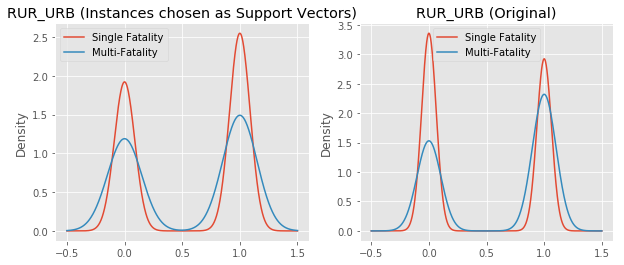

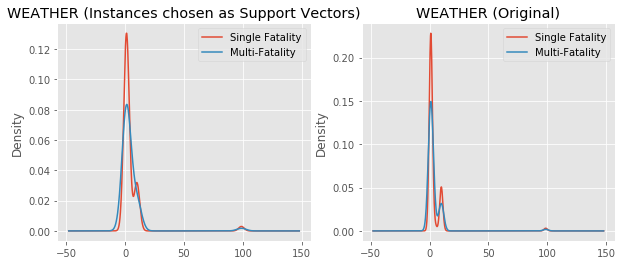

In [15]:
# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['FATALS'])
df_grouped = df_imputed.groupby(['FATALS'])

# plot KDE of Different variables
vars_to_plot = ['DRUNK_DR','TOT_PERS','RUR_URB','WEATHER']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Single Fatality','Multi-Fatality'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Single Fatality','Multi-Fatality'])
    plt.title(v+' (Original)')


By reviewing the support vectors vs. the original data in these graphs, we can see that the separation in distributions is not as great as the separation for the original data. This is because the support vectors tend to be instances on the edge of the class boundaries and also instances that are classified incorrectly in the training data.


## Model Advantages

Each of the models do a fairly good job with prediction accuracy.  This is in large part due to the large number of single-fatality accidents in the dataset.  This leads to good model accuracy by almost always predicting single fatality accidents instead of multi-fatality accidents.  A balanced, scaled model appear to be our best predictor.

### Model 1

Model 1 was a logistic regression model with parameters of: Penalty = l2, Cost = 1.0, class_weight = None.  The accuracy of this model is good at about 92%, and from the confusion matricies we see a lot of True Positive predictions.  The model appears to predict more False Positives than it does False Negatives, and very few True Negatives.  This model definitely errs on the side of predicting single-fatality accidents.  Ten-fold cross validation ran efficiently with relatively short training time.

### Model 2

Model 2 was a logistic regression model with parameters of: Penalty = l2, Cost = 0.5, class_weight='balanced'.  The accuracy of this model is significantly lower than the previous model, at approximately 77%. From the confusion matricies we still see a lot of True Positive predictions, but also many more False Negative predictions than the previous model.  There are more True Negatives predictions, but this comes at the cost of a loss in overall accuracy.  This model errs on the side of predicting more multi-fatality accidents than the previous model.  Cross validation also ran efficiently with a relatively short training time.

### Model 3

Model 3 was a scaled logistic regression model with parameters of: Penalty='l2', C=0.05, class_weight=None.
This model provides good accuracy at about 92-93%.  There are still a large number of True Positive results.  It tends to predict more False Positive results than False Negative results. As with the other logistic regression models, this model ran efficiently with relatively short training time.

### Support Vector Machine model

**Added for Resubmission**

***This model using support vectors was the most accurate model, with an accuracy of 93%. Although this model was the most technically accurate model, it always predicted to be true. Due to the nature of this model, we are not considering it for our analysis. ***


## Interpret Feature Importance

Now we will review the feature coefficients of our preferred model.  The coefficient weights are from Model 3, with pararmeters of: Scaled/Normalized, Penalty=l2, Cost=0.5, class_weight=None.  We will interpret the key coefficients of the model.


In [16]:
# Model 3 - Interpretation of weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df_imputed.columns
for coef, name in sorted(zip(weights,variable_names)):
    print(name, 'has weight of', coef[0])
    

TIME has weight of -0.0795538203427
SCH_BUS has weight of -0.0740399556536
LATITUDE has weight of -0.0622129362232
WRK_ZONE has weight of -0.0334989473756
WEATHER has weight of -0.0249829453892
WEATHER2 has weight of -0.0239687039473
DAY_WEEK has weight of 0.00144741144785
WEATHER1 has weight of 0.0246760993869
MONTH has weight of 0.0407834713384
LONGITUD has weight of 0.0512831649608
HARM_EV has weight of 0.133471999859
DRUNK_DR has weight of 0.244592090401
RUR_URB has weight of 0.335168291062
TOT_PERS has weight of 0.654996807289


#### Interpretation of key features of the model

From the coefficients, we can see that the number of people (TOT_PERS) involved in the accident has the greatest weight as a positive predictor of multi-fatality accidents.  It intuitively makes sense that more fatalities occur when there are more people involved in the accident.  

Proximity to populated areas (RUR_URB) was also positively correlelated to predicting accidents with multiple fatalities.  Accidents occuring in urban areas were good predictors of multi-fatality accidents. 

As you would expect, drunk driving (DRUNK_DR) was also a significant predictor for multi-fatality accidents, with a moderately positive correlation.  

Finally, weather (WEATHER/WEATHER1/WEATHER2) also plays a somewhat limited role in predicting multi-fatality accidents. 

Many of the remaining attributes don't appear to have very significant weightings in the predictive model.


## Interpret Support Vectors








**Added for Resubmission**

***For our KDE plots, there are four line graphs of DRUNK\_DR, TOT\_PERS, RUR\_URB, and WEATHER based on their Support Vector Machine vs Original values. These plots show the distribution of all the data points versus those chosen by the support vectors algorithm. ***

Based on the count of fatalities in the beginning of this Jupyter Notebook, there was a large difference between the count of Single-Fatality compared to Multi-Fatality accidents (29,816 Single vs. 2,350 Multi). As a result, we expect that the Single Fatalities have a higher density since there were significantly more samples of Single Fatalities vs Multi-Fatalities. Logistic Regression and Support Vector Machine modeling was possible with the size of our population. We chose not perform a stochastic gradient descent since we were able to perform the other modeling methods. 
